### Lane segmentation

In [2]:
import gym
import numpy as np
import gym_donkeycar
import time 
import matplotlib.pyplot as plt

In [5]:
env = gym.make("donkey-generated-track-v0")

INFO:gym_donkeycar.core.client:connecting to localhost:9091 
INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:done sending car config.


starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: max_cte 5.0
Setting default: frame_skip 2
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: host localhost
Setting default: port 9091


In [6]:
obs = env.reset()

In [7]:
print(obs.shape)

(120, 160, 3)


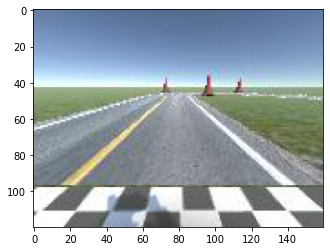

In [7]:
plt.imshow(obs)

In [15]:
env.close()

## Get the images

In [1]:
images_ids = ['0', '1283', '1427', '1893', '278', '308', '313', '500', '565'] 

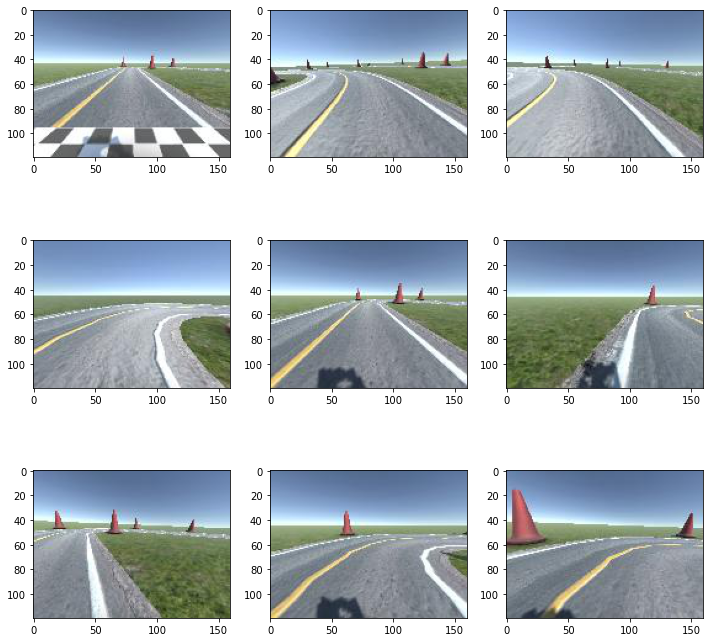

In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))
for i in range(9):
    im = mpimg.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    plt.imshow(im)

## Without lane detection, just change to RGB

In [215]:
def rgb2gray(rgb):
    """
    take a numpy rgb image return a new single channel image converted to greyscale
    """
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def process_image(obs):
    global LANE_SEGMENTATION 
    obs = rgb2gray(obs)
    print("shape after converting to gray", obs.shape)
    obs = cv2.resize(obs, (img_rows, img_cols))
    if LANE_SEGMENTATION: obs = detect_edge(obs)
    return obs

shape after converting to gray (80, 80)
shape after converting to gray (80, 80)
shape after converting to gray (80, 80)
shape after converting to gray (80, 80)
shape after converting to gray (80, 80)
shape after converting to gray (80, 80)
shape after converting to gray (80, 80)
shape after converting to gray (80, 80)
shape after converting to gray (80, 80)


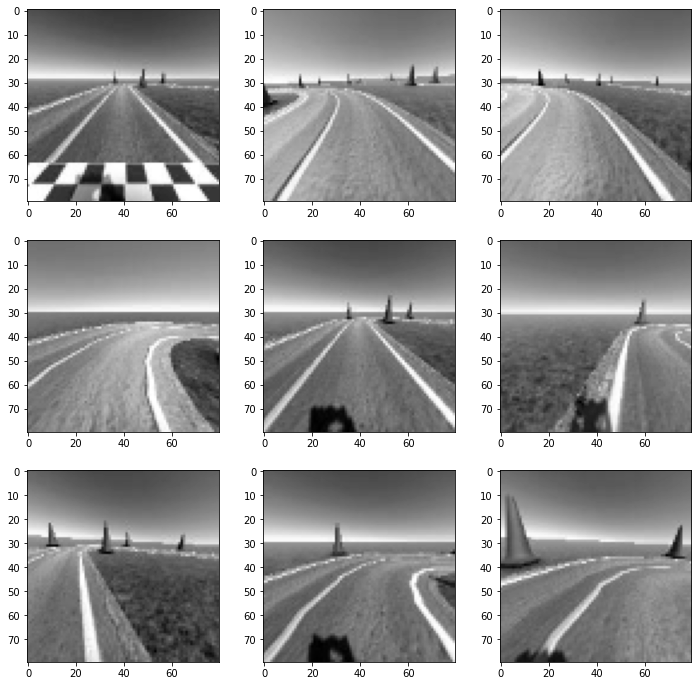

In [216]:
LANE_SEGMENTATION = False
img_rows = 80 
img_cols = 80

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))
for i in range(9):
    im = mpimg.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    im = process_image(im)
    plt.imshow(im, cmap="gray")

In [120]:
# try to see the data in the image
im

array([[126.123   , 125.555   , 124.920875, ..., 118.824   , 119.449   ,
        120.199   ],
       [129.123   , 128.555   , 128.037125, ..., 119.949   , 120.574   ,
        120.949   ],
       [130.803   , 130.216   , 129.6635  , ..., 121.449   , 122.449   ,
        122.699   ],
       ...,
       [119.52    , 122.7155  , 116.161   , ..., 151.955   , 164.705   ,
        162.205   ],
       [113.77    , 116.5905  , 106.911   , ..., 152.205   , 159.33    ,
        158.33    ],
       [109.645   , 113.2155  , 106.161   , ..., 146.955   , 139.83    ,
        159.83    ]])

In [121]:
im.shape

(80, 80)

In [122]:
len(np.unique(im))

5068

### apparently this is converted to gray using "perceived brightness"

## My initial version of lane detection

In [123]:
def rgb2gray(rgb):
    """
    take a numpy rgb image return a new single channel image converted to greyscale
    """
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def process_image(obs):
    global LANE_SEGMENTATION 
    obs = rgb2gray(obs)
    obs = cv2.resize(obs, (img_rows, img_cols))
    if LANE_SEGMENTATION: obs = detect_edge(obs)
    return obs

def detect_edge(image, kernel_size=7, low_threshold=80, high_threshold=90):
    im_blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(np.uint8(im_blurred), low_threshold, high_threshold)

    return im_edge

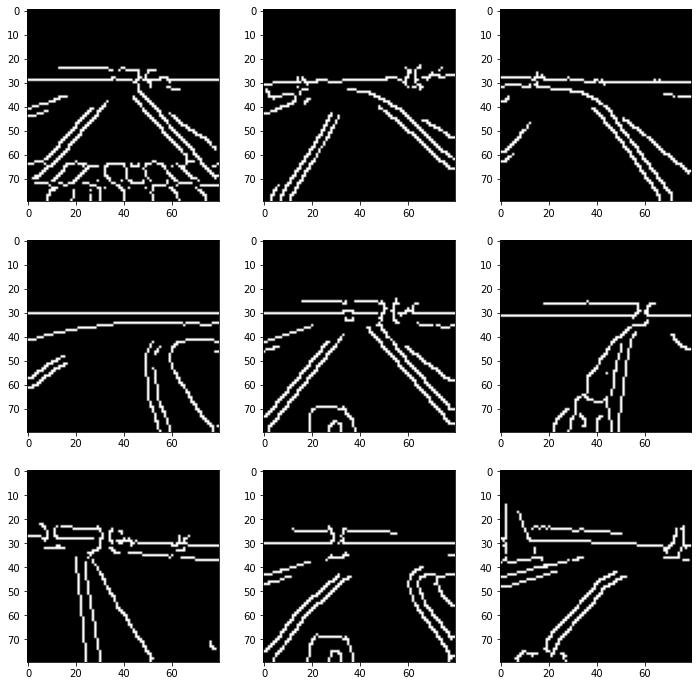

In [132]:
LANE_SEGMENTATION = True
img_rows = 80 
img_cols = 80

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))
for i in range(9):
    im = mpimg.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    im = process_image(im)
    plt.imshow(im, cmap = "gray")

In [125]:
im

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [126]:
np.unique(im)

array([  0, 255], dtype=uint8)

In [127]:
im.shape

(80, 80)

## Ok now let's try Chun Jye's version of lane detection

In [183]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

Edges_Detection = True

ROI_y = 20

def detect_edges(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

def preprocess_image(image):
    grey_only = not Edges_Detection
    global x
    
    if grey_only:
        grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grey = np.stack((grey, )*3, axis=-1)
        # print("Processed Image Shape: {}".format(grey.shape))
        return grey
    img = cv2.GaussianBlur(image, (5, 5), 0)
    edges = detect_edges(img, low_threshold=80, high_threshold=200)
    plt.imshow(edges)
    
    #cropped edges
    edges[0:ROI_y,:] = 0
    edges = cv2.merge((edges, edges, edges))
    
    return edges

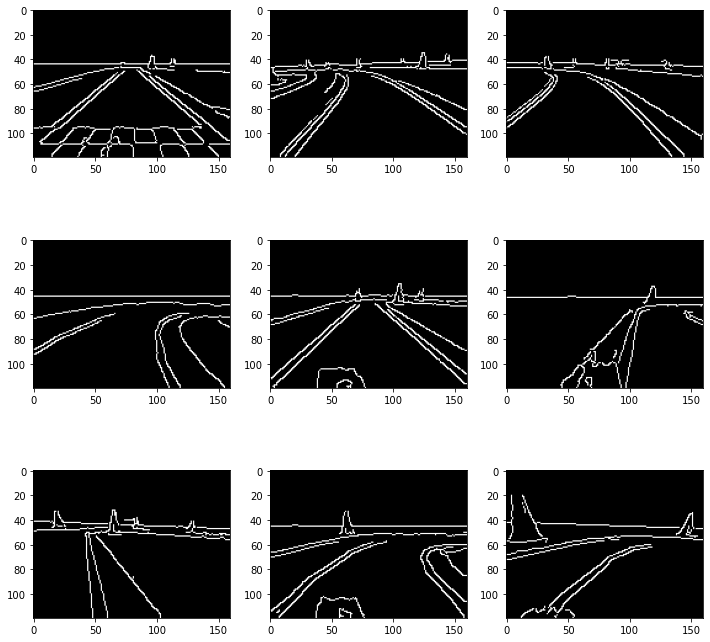

In [184]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))

for i in range(9):
    im = cv2.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    im = preprocess_image(im)
    plt.imshow(im)

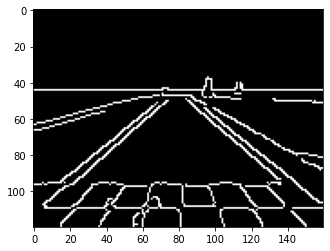

In [165]:
i = 0
im = cv2.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
im = preprocess_image(im)
plt.imshow(im)

In [166]:
im.shape

(120, 160, 3)

In [173]:
import copy

edges = copy.deepcopy(im[:, :, 0])
edges.shape

(120, 160)

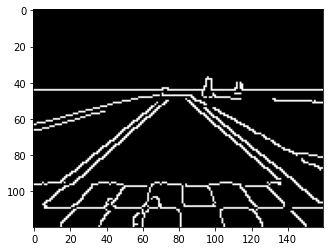

In [174]:
plt.imshow(edges, cmap="gray")

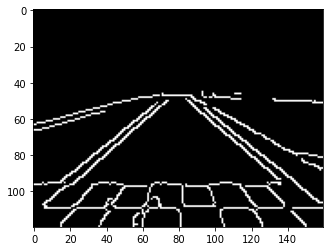

In [177]:
edges[0:45,:] = 0
plt.imshow(edges, cmap="gray")

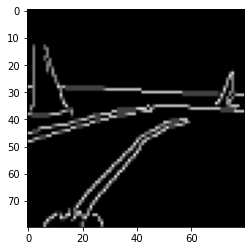

In [185]:
# what if we resize to 80, 80?
plt.imshow(cv2.resize(im, (80,80)))

In [188]:
np.unique(cv2.resize(im, (80,80)))

array([  0,  32,  64,  96, 127, 159, 191, 223], dtype=uint8)

**Resizing after edge detection results in such bad quality image and also non-pure image (not just black and white)**

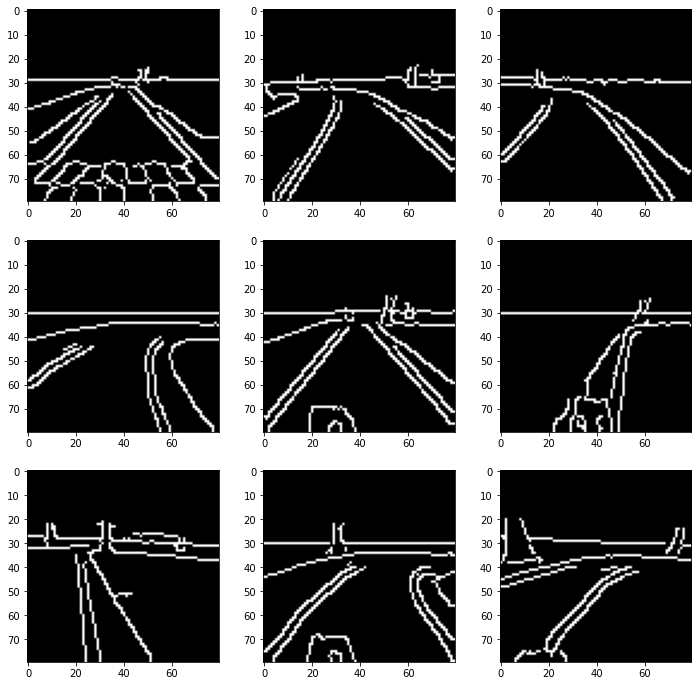

In [199]:
# try resizing before edge detection
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

Edges_Detection = True

ROI_y = 20

def detect_edges(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

def preprocess_image(image):
    grey_only = not Edges_Detection
    global x
    
    if grey_only:
        grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grey = np.stack((grey, )*3, axis=-1)
        # print("Processed Image Shape: {}".format(grey.shape))
        return grey
    image = cv2.resize(image, (80,80))
    img = cv2.GaussianBlur(image, (5, 5), 0)
    edges = detect_edges(img, low_threshold=80, high_threshold=200)
    plt.imshow(edges)
    
    #cropped edges
    edges[0:ROI_y,:] = 0
    edges = cv2.merge((edges, edges, edges))
    
    return edges

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))

for i in range(9):
    im = cv2.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    im = preprocess_image(im)
    plt.imshow(im)

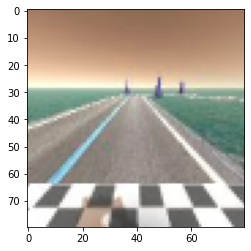

In [203]:
i=0
im = cv2.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
plt.imshow(cv2.resize(im, (80,80))) # cv2.resize actually change the image to BGR

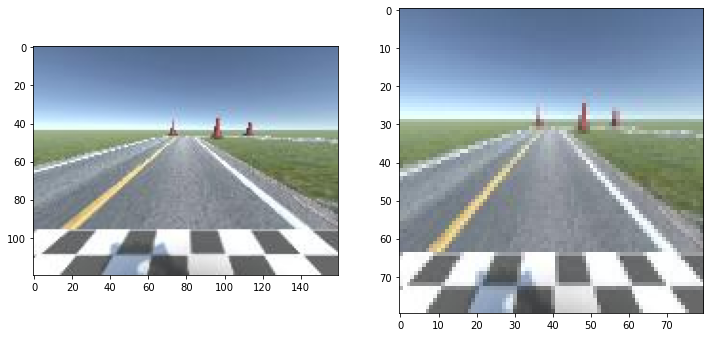

In [209]:
i=0
im = cv2.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
f = plt.figure(figsize=(12,12))

f.add_subplot(1,2,1)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
f.add_subplot(1,2,2)
plt.imshow(cv2.cvtColor(cv2.resize(im, (80,80)), cv2.COLOR_BGR2RGB)) # cv2.resize actually change the image to BGR

**cv2.resize results in a distorted image. We need to somehow fix this**

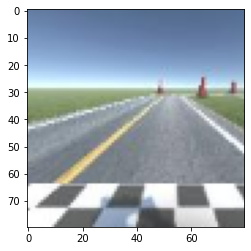

In [205]:
i=0
im = cv2.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
crop_img = im[:, :120]
plt.imshow(cv2.cvtColor(cv2.resize(crop_img, (80,80)), cv2.COLOR_BGR2RGB)) # cv2.resize actually change the image to BGR

**cropping the original image to match the aspect ratio doesn't help**

In [179]:
# try converting to gray before doing edge detection
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

Edges_Detection = True

ROI_y = 20

def detect_edges(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

def preprocess_image(image):
    grey_only = not Edges_Detection
    global x
    
    
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grey = np.stack((grey, )*3, axis=-1)
        # print("Processed Image Shape: {}".format(grey.shape))
    if grey_only:    return grey
    img = cv2.GaussianBlur(grey, (5, 5), 0)
    edges = detect_edges(img, low_threshold=80, high_threshold=200)
    plt.imshow(edges)
    
    #cropped edges
    edges[0:ROI_y,:] = 0
    edges = cv2.merge((edges, edges, edges))
    
    return edges

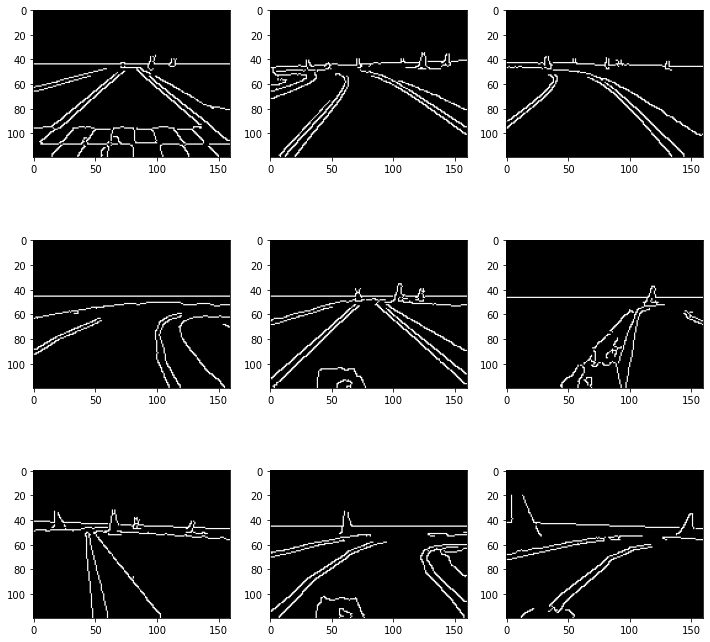

In [180]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))

for i in range(9):
    im = cv2.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    im = preprocess_image(im)
    plt.imshow(im)

### Greying before doing lane detection results in more breaks for the lane! Let's not do it

## **Ok, I will first do the lane detection without the crop. This is my edit1. Note that I will only return a single color channel, and note that I resize without greying the image before feeding it into CannyEdge. I also will not keep the aspect ratio, for now**

In [210]:
def rgb2gray(rgb):
    """
    take a numpy rgb image return a new single channel image converted to greyscale
    """
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def process_image(obs):
    global LANE_SEGMENTATION 
    obs = cv2.resize(obs, (img_rows, img_cols))
    if LANE_SEGMENTATION: 
        obs = detect_edge(obs)
    else:
        obs = rgb2gray(obs)
        
    return obs

def detect_edge(image, kernel_size=5, low_threshold=80, high_threshold=200):
    im_blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(np.uint8(im_blurred), low_threshold, high_threshold)

    return im_edge

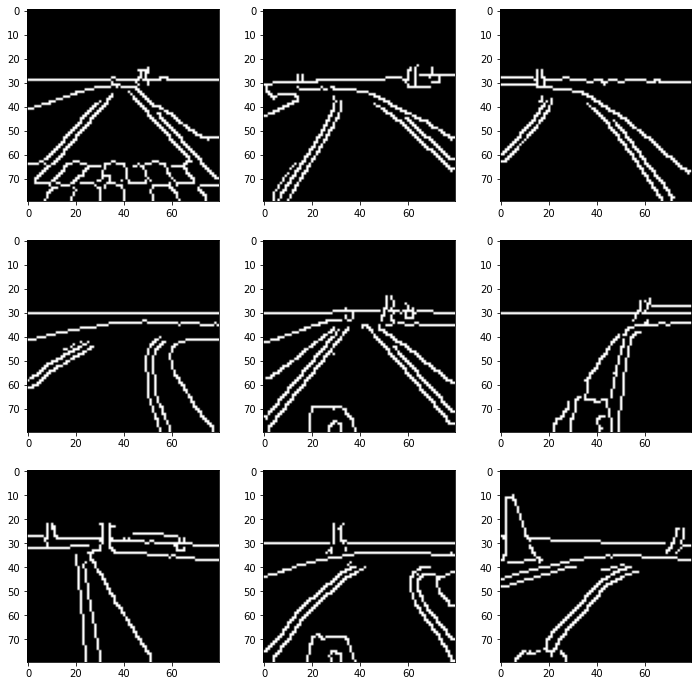

In [213]:
LANE_SEGMENTATION = True
img_rows = 80 
img_cols = 80

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))
for i in range(9):
    im = mpimg.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    im = process_image(im)
    plt.imshow(im, cmap = "gray")

In [214]:
np.unique(im)

array([  0, 255], dtype=uint8)

## Edit2: Try keeping the same aspect ratio by **padding** the y axis

In [218]:
i=0
im = cv2.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))

40


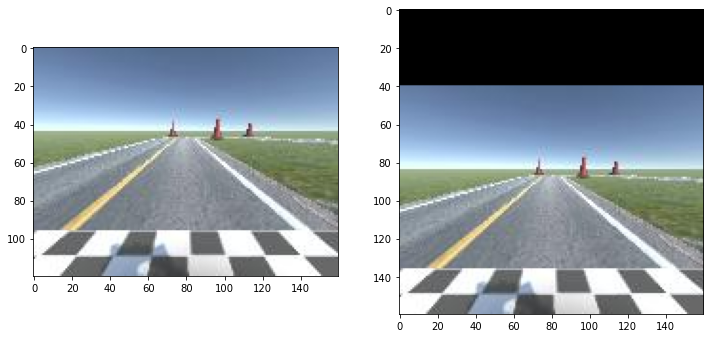

In [224]:
top = im.shape[1] - im.shape[0]
print(top)
im_padded = cv2.copyMakeBorder(im, top, 0, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
f = plt.figure(figsize=(12,12))
f.add_subplot(1,2,1)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
f.add_subplot(1,2,2)
plt.imshow(cv2.cvtColor(im_padded, cv2.COLOR_BGR2RGB))

In [225]:
def rgb2gray(rgb):
    """
    take a numpy rgb image return a new single channel image converted to greyscale
    """
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def process_image(obs):
    global LANE_SEGMENTATION 
    
    top = obs.shape[1] - obs.shape[0]
    obs = cv2.copyMakeBorder(obs, top, 0, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
    obs = cv2.resize(obs, (img_rows, img_cols))
    if LANE_SEGMENTATION: 
        obs = detect_edge(obs)
    else:
        obs = rgb2gray(obs)
        
    return obs

def detect_edge(image, kernel_size=5, low_threshold=80, high_threshold=200):
    im_blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(np.uint8(im_blurred), low_threshold, high_threshold)

    return im_edge

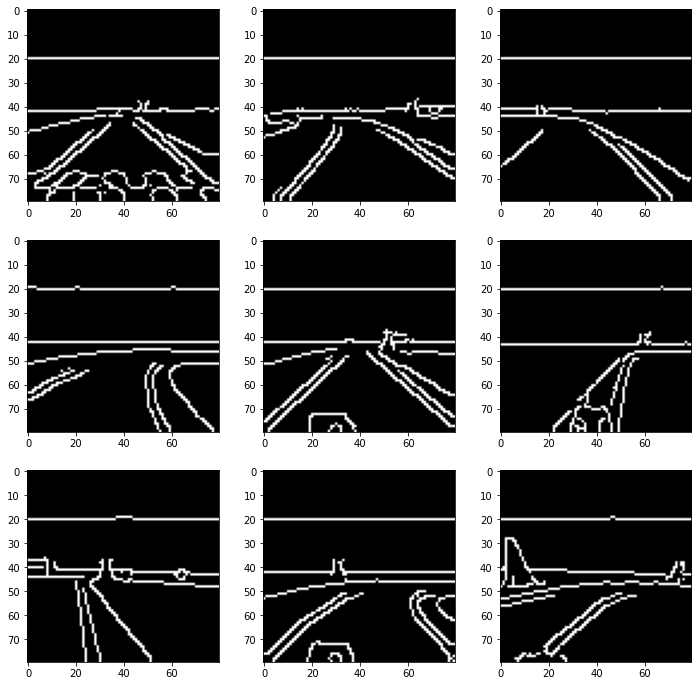

In [226]:
LANE_SEGMENTATION = True
img_rows = 80 
img_cols = 80

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))
for i in range(9):
    im = mpimg.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    im = process_image(im)
    plt.imshow(im, cmap = "gray")

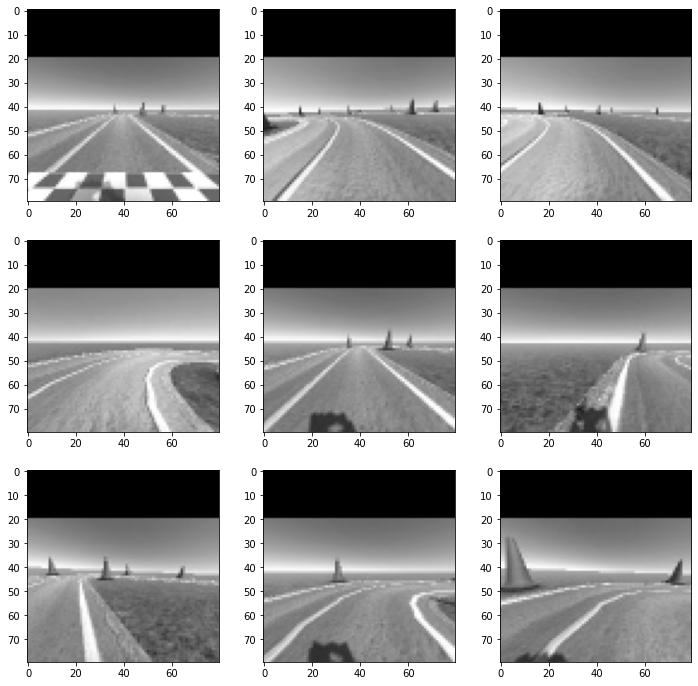

In [227]:
LANE_SEGMENTATION = False
img_rows = 80 
img_cols = 80

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))
for i in range(9):
    im = mpimg.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    im = process_image(im)
    plt.imshow(im, cmap = "gray")

**Quite weird to pad like this also**

In [235]:
# maybe can try tensorflow?
import tensorflow as tf
def rgb2gray(rgb):
    """
    take a numpy rgb image return a new single channel image converted to greyscale
    """
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def process_image(obs):
    global LANE_SEGMENTATION 
    
    top = obs.shape[1] - obs.shape[0]
    
    obs = tf.image.resize_with_pad(obs, img_rows, img_cols)
    obs = np.float32(obs)
    if LANE_SEGMENTATION: 
        obs = detect_edge(obs)
    else:
        obs = rgb2gray(obs)
        
    return obs

def detect_edge(image, kernel_size=5, low_threshold=80, high_threshold=200):
    im_blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(np.uint8(im_blurred), low_threshold, high_threshold)

    return im_edge

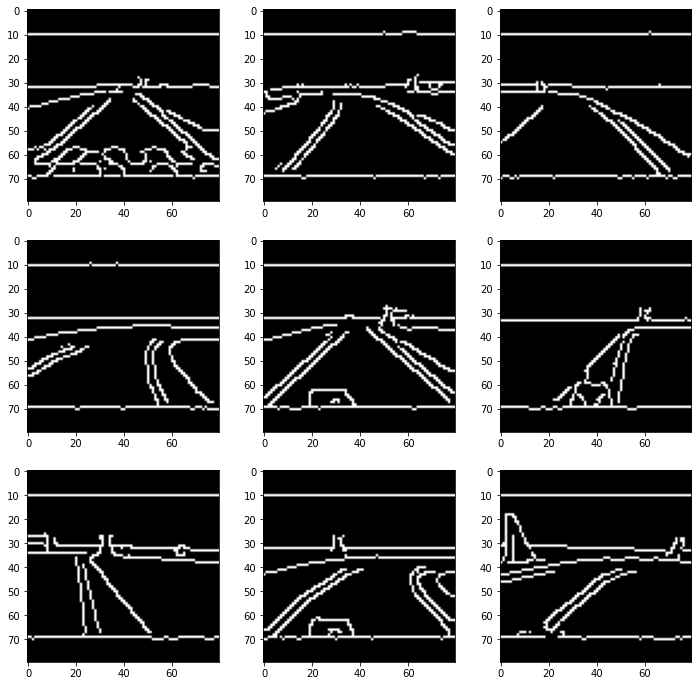

In [236]:
LANE_SEGMENTATION = True
img_rows = 80 
img_cols = 80

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))
for i in range(9):
    im = mpimg.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    im = process_image(im)
    plt.imshow(im, cmap = "gray")

**Nah, the padding is not controllable so that it should only pad the top. Ok for the one below I'm gonna just use BORDER_REPLICATE**

40


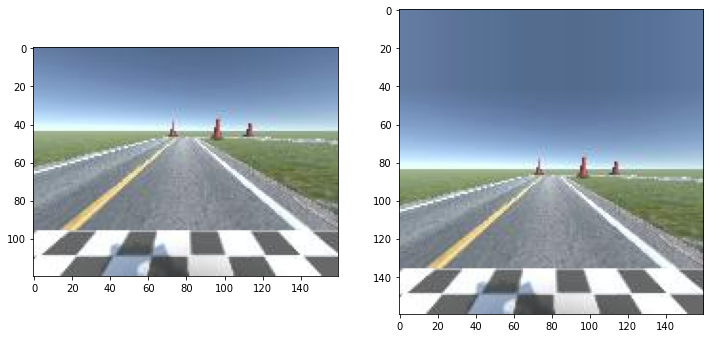

In [239]:
top = im.shape[1] - im.shape[0]
print(top)
im_padded = cv2.copyMakeBorder(im, top, 0, 0, 0, cv2.BORDER_REPLICATE)
f = plt.figure(figsize=(12,12))
f.add_subplot(1,2,1)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
f.add_subplot(1,2,2)
plt.imshow(cv2.cvtColor(im_padded, cv2.COLOR_BGR2RGB))

In [240]:
def rgb2gray(rgb):
    """
    take a numpy rgb image return a new single channel image converted to greyscale
    """
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def process_image(obs):
    global LANE_SEGMENTATION 
    
    top = obs.shape[1] - obs.shape[0]
    obs = cv2.copyMakeBorder(obs, top, 0, 0, 0, cv2.BORDER_REPLICATE)
    obs = cv2.resize(obs, (img_rows, img_cols))
    if LANE_SEGMENTATION: 
        obs = detect_edge(obs)
    else:
        obs = rgb2gray(obs)
        
    return obs

def detect_edge(image, kernel_size=5, low_threshold=80, high_threshold=200):
    im_blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(np.uint8(im_blurred), low_threshold, high_threshold)

    return im_edge

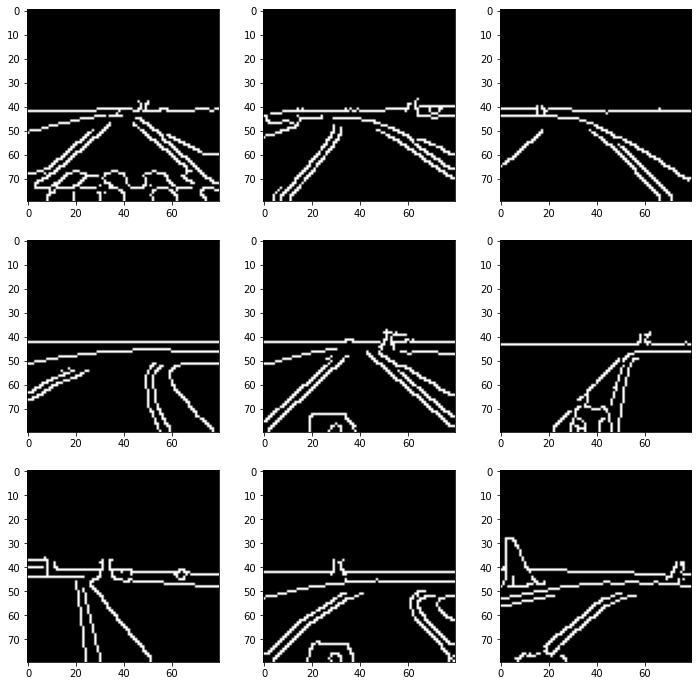

In [244]:
LANE_SEGMENTATION = True
img_rows = 80 
img_cols = 80

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))
for i in range(9):
    im = mpimg.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    im = process_image(im)
    plt.imshow(im, cmap = "gray")

In [245]:
np.unique(im)

array([  0, 255], dtype=uint8)

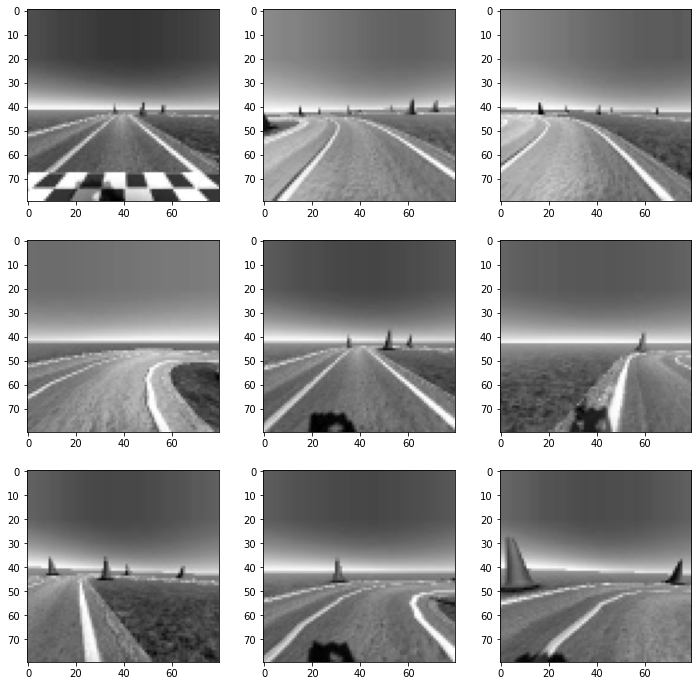

In [242]:
LANE_SEGMENTATION = False
img_rows = 80 
img_cols = 80

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))
for i in range(9):
    im = mpimg.imread("images/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    im = process_image(im)
    plt.imshow(im, cmap = "gray")

In [243]:
np.unique(im)

array([ 41.01 ,  42.264,  44.164, ..., 248.521, 248.722, 251.582])

## Lane detection in bridging between environments

In [26]:
def rgb2gray(rgb):
    """
    take a numpy rgb image return a new single channel image converted to greyscale
    """
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def process_image(obs):
    global LANE_SEGMENTATION 
    
    top = obs.shape[1] - obs.shape[0]
    obs = cv2.copyMakeBorder(obs, top, 0, 0, 0, cv2.BORDER_REPLICATE)
    obs = cv2.resize(obs, (img_rows, img_cols))
    if LANE_SEGMENTATION: 
        obs = detect_edge(obs)
    else:
        obs = rgb2gray(obs)
        
    return obs

def detect_edge(image, kernel_size=5, low_threshold=80, high_threshold=200):
    im_blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(np.uint8(im_blurred), low_threshold, high_threshold)
    
    return im_edge

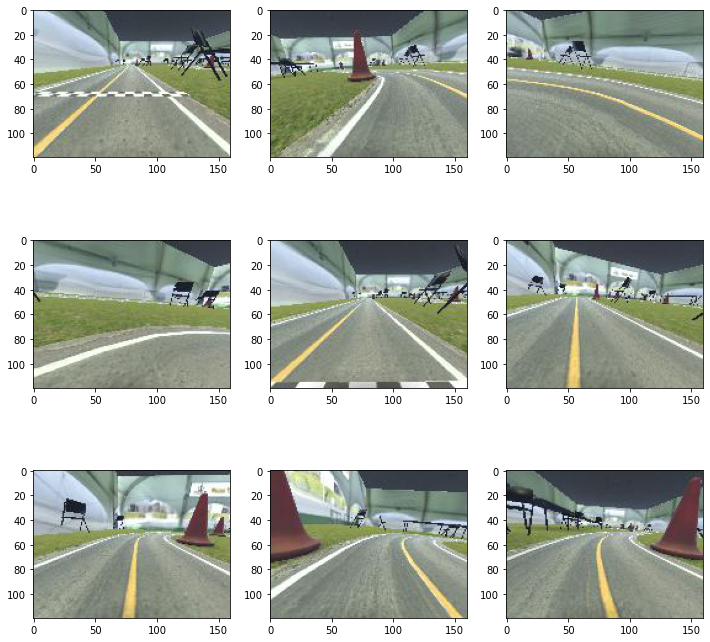

In [19]:
f = plt.figure(figsize=(12,12))
for i in range(9):
    im = mpimg.imread("images_warren/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
#     im = process_image(im)
    plt.imshow(im, cmap = "gray")

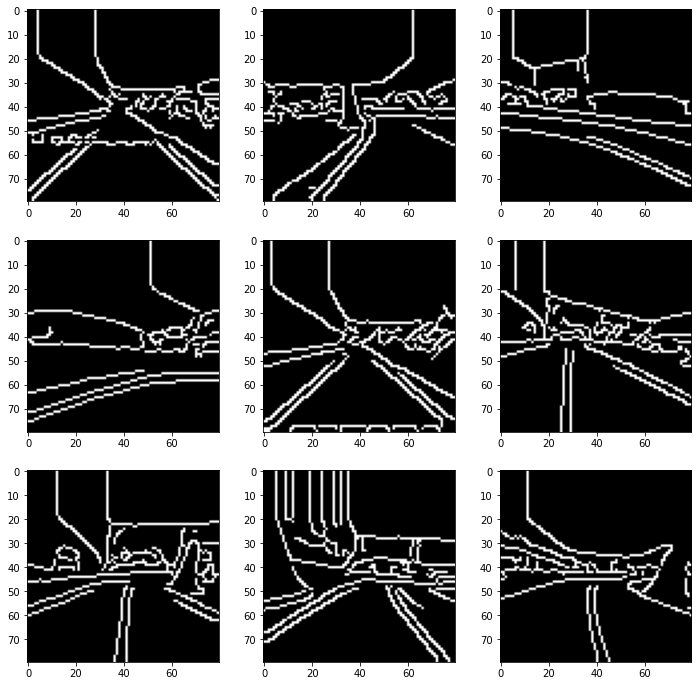

In [27]:
images_ids = [0, 1126, 1162, 1194, 180, 478, 572, 768, 944]

LANE_SEGMENTATION = True
img_rows = 80 
img_cols = 80

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f = plt.figure(figsize=(12,12))
for i in range(9):
    im = mpimg.imread("images_warren/{}_cam-image_array_.jpg".format(images_ids[i]))
    f.add_subplot(3,3,i+1)
    im = process_image(im)
    plt.imshow(im, cmap = "gray")

## Playing with different parameters of CannyEdge

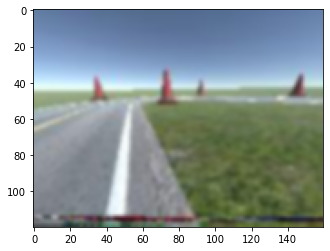

In [27]:
image = obs
kernel_size = 5
plt.imshow(cv2.GaussianBlur(image, (kernel_size, kernel_size), 0))

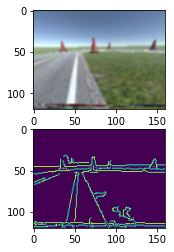

In [22]:
image = obs
kernel_size = 5
f = plt.figure()
blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
f.add_subplot(2,1,1)
plt.imshow(blurred)
edges = detect_edges(blurred, low_threshold=50, high_threshold=150)
f.add_subplot(2,1,2)
plt.imshow(edges)

In [67]:
action = np.array([-1, 0.5])  
# execute the action
obs, reward, done, info = env.step(action)
print(info["cte"])
print(info["speed"])
print(reward, done)
time.sleep(0.5)
action = np.array([0.0, 0.0])  
# execute the action
obs, reward, done, info = env.step(action)
print(info["cte"])
print(info["speed"])
print(reward, done)

-17.30462
1.005604
-1.0 True
-17.83346
1.582679
-1.0 True


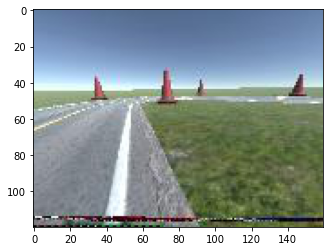

In [66]:
plt.imshow(obs)

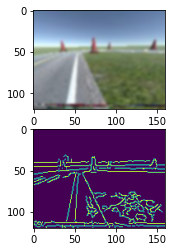

In [37]:
image = obs
kernel_size = 7
f = plt.figure()
blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
f.add_subplot(2,1,1)
plt.imshow(blurred)
edges = detect_edges(blurred, low_threshold=80, high_threshold=20)
f.add_subplot(2,1,2)
plt.imshow(edges)

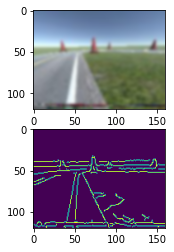

In [38]:
image = obs
kernel_size = 9
f = plt.figure()
blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
f.add_subplot(2,1,1)
plt.imshow(blurred)
edges = detect_edges(blurred, low_threshold=80, high_threshold=20)
f.add_subplot(2,1,2)
plt.imshow(edges)

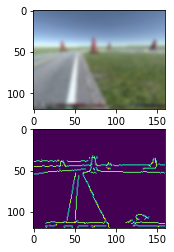

In [35]:
image = obs
kernel_size = 11
f = plt.figure()
blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
f.add_subplot(2,1,1)
plt.imshow(blurred)
edges = detect_edges(blurred, low_threshold=80, high_threshold=20)
f.add_subplot(2,1,2)
plt.imshow(edges)

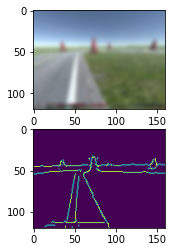

In [44]:
image = obs
kernel_size = 13
f = plt.figure()
blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
f.add_subplot(2,1,1)
plt.imshow(blurred)
edges = detect_edges(blurred, low_threshold=80, high_threshold=20)
f.add_subplot(2,1,2)
plt.imshow(edges)

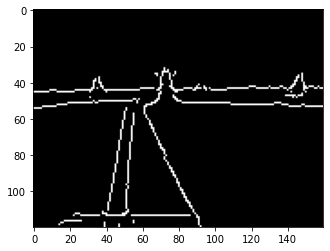

In [45]:
plt.imshow(cv2.merge((edges, edges, edges)))

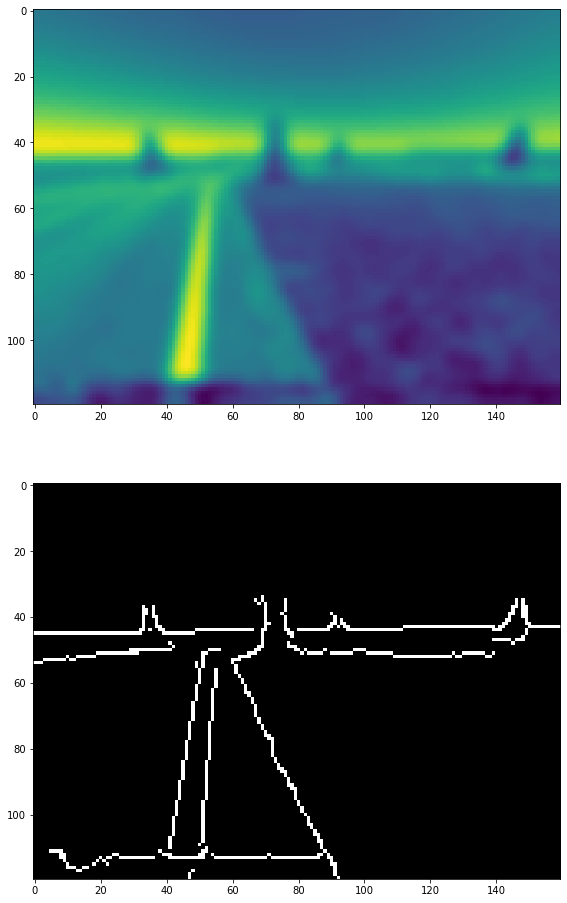

In [73]:
image = obs[:]
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel_size = 13
f = plt.figure(figsize=(16,16))
blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
f.add_subplot(2,1,1)
plt.imshow(blurred)
edges = detect_edges(blurred, low_threshold=80, high_threshold=20)
f.add_subplot(2,1,2)
plt.imshow(edges, cmap="gray")

(120, 160)


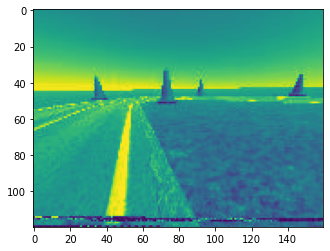

In [60]:
image = obs[:]
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)
print(image.shape)

(120, 160, 3)


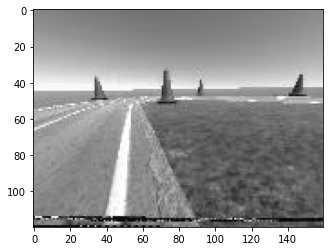

In [61]:
image = obs[:]
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
grey = np.stack((grey, )*3, axis=-1)
plt.imshow(grey)
print(grey.shape)

In [ ]:
def process_image(obs):
        obs = self.rgb2gray(obs)
        obs = cv2.resize(obs, (img_rows, img_cols))
        return obs
plt.imshow(process_image(obs)

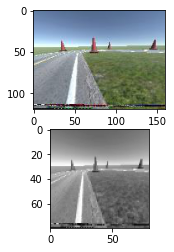

In [69]:
img_rows, img_cols = 80, 80
def rgb2gray(rgb):
    """
    take a numpy rgb image return a new single channel image converted to greyscale
    """
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def process_image(obs):
    obs = rgb2gray(obs)
    obs = cv2.resize(obs, (img_rows, img_cols))
    return obs

processed = process_image(obs)
f = plt.figure()
f.add_subplot(2,1,1)
plt.imshow(obs)
f.add_subplot(2,1,2)
plt.imshow(processed, cmap="gray")

In [68]:
print(processed.shape)

(80, 80)


In [7]:
env.close()

## Test with images in the folder first

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image

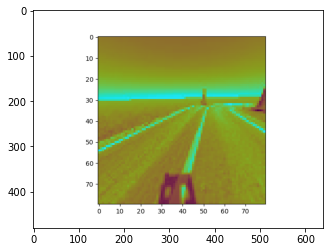

In [13]:
im = cv2.imread("images/20.png")
plt.imshow(im)

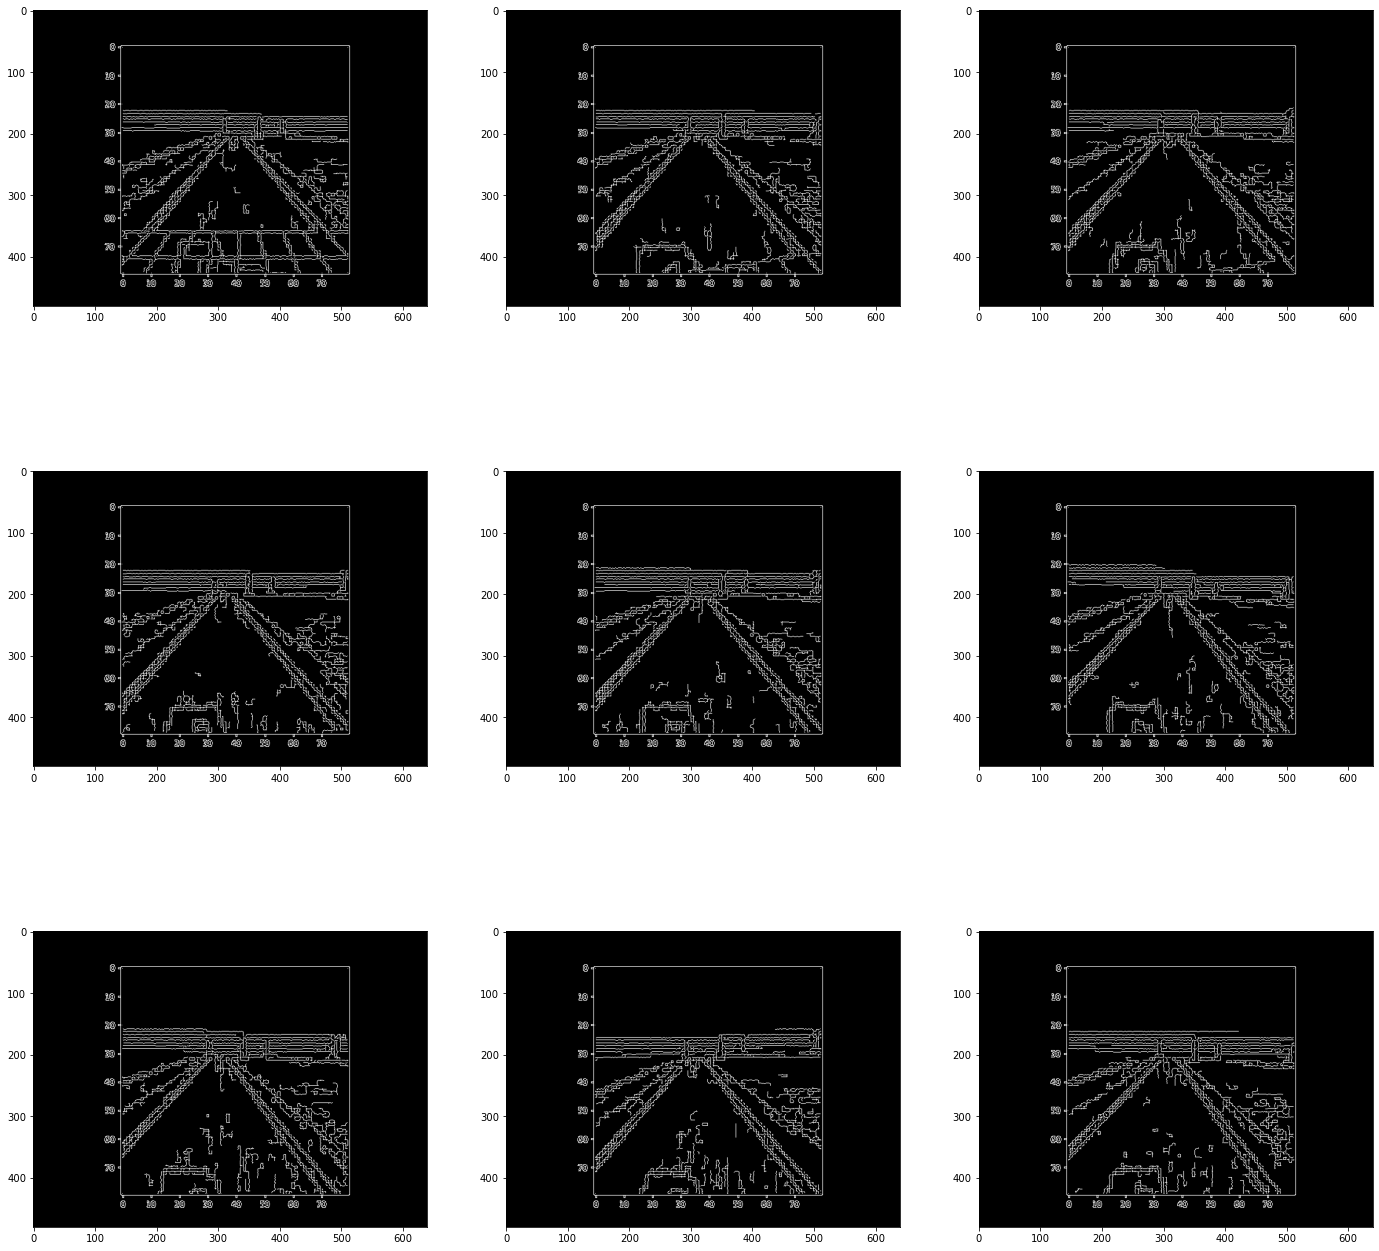

In [32]:
low_threshold = 20
high_threshold = 80 
kernel_size = 3
f = plt.figure(figsize=(24,24))
for i in range(9):
    im = cv2.imread("{}.png".format(i))
    im_blurred = cv2.GaussianBlur(im, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(im_blurred, low_threshold, high_threshold)
    f.add_subplot(3,3,i+1)
    plt.imshow(im_edge, cmap="gray")

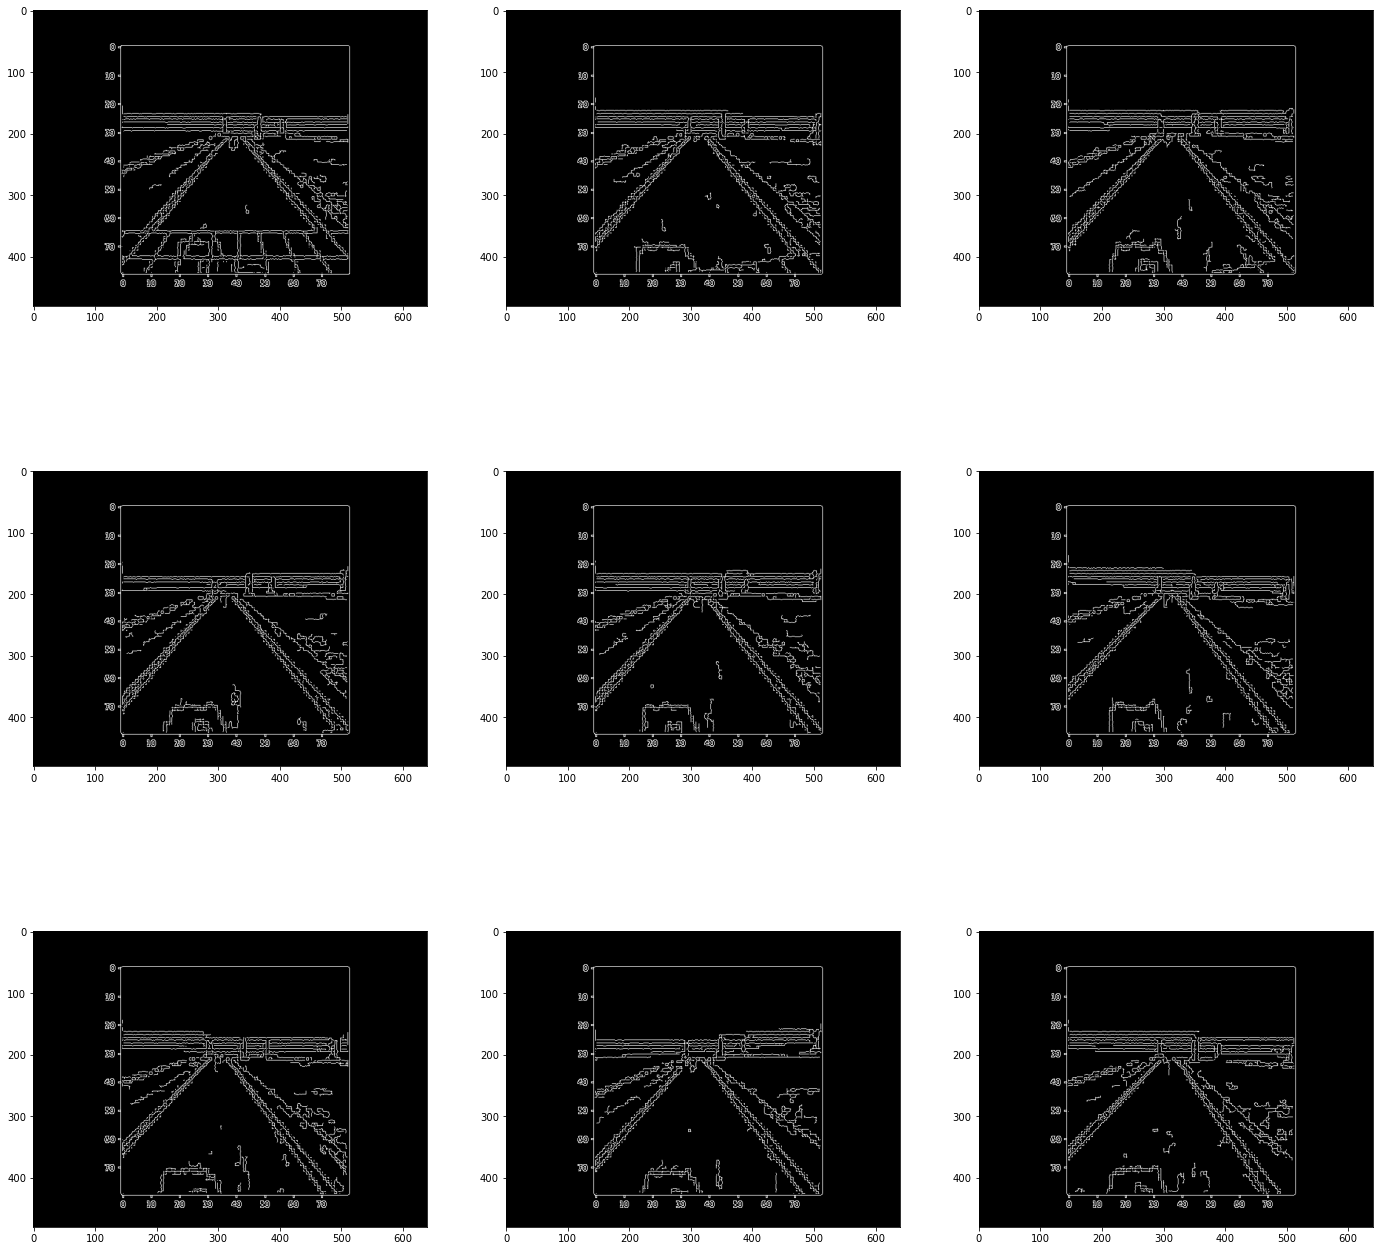

In [30]:
low_threshold = 20
high_threshold = 80 
kernel_size = 5
f = plt.figure(figsize=(24,24))
for i in range(9):
    im = cv2.imread("{}.png".format(i))
    im_blurred = cv2.GaussianBlur(im, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(im_blurred, low_threshold, high_threshold)
    f.add_subplot(3,3,i+1)
    plt.imshow(im_edge, cmap="gray")

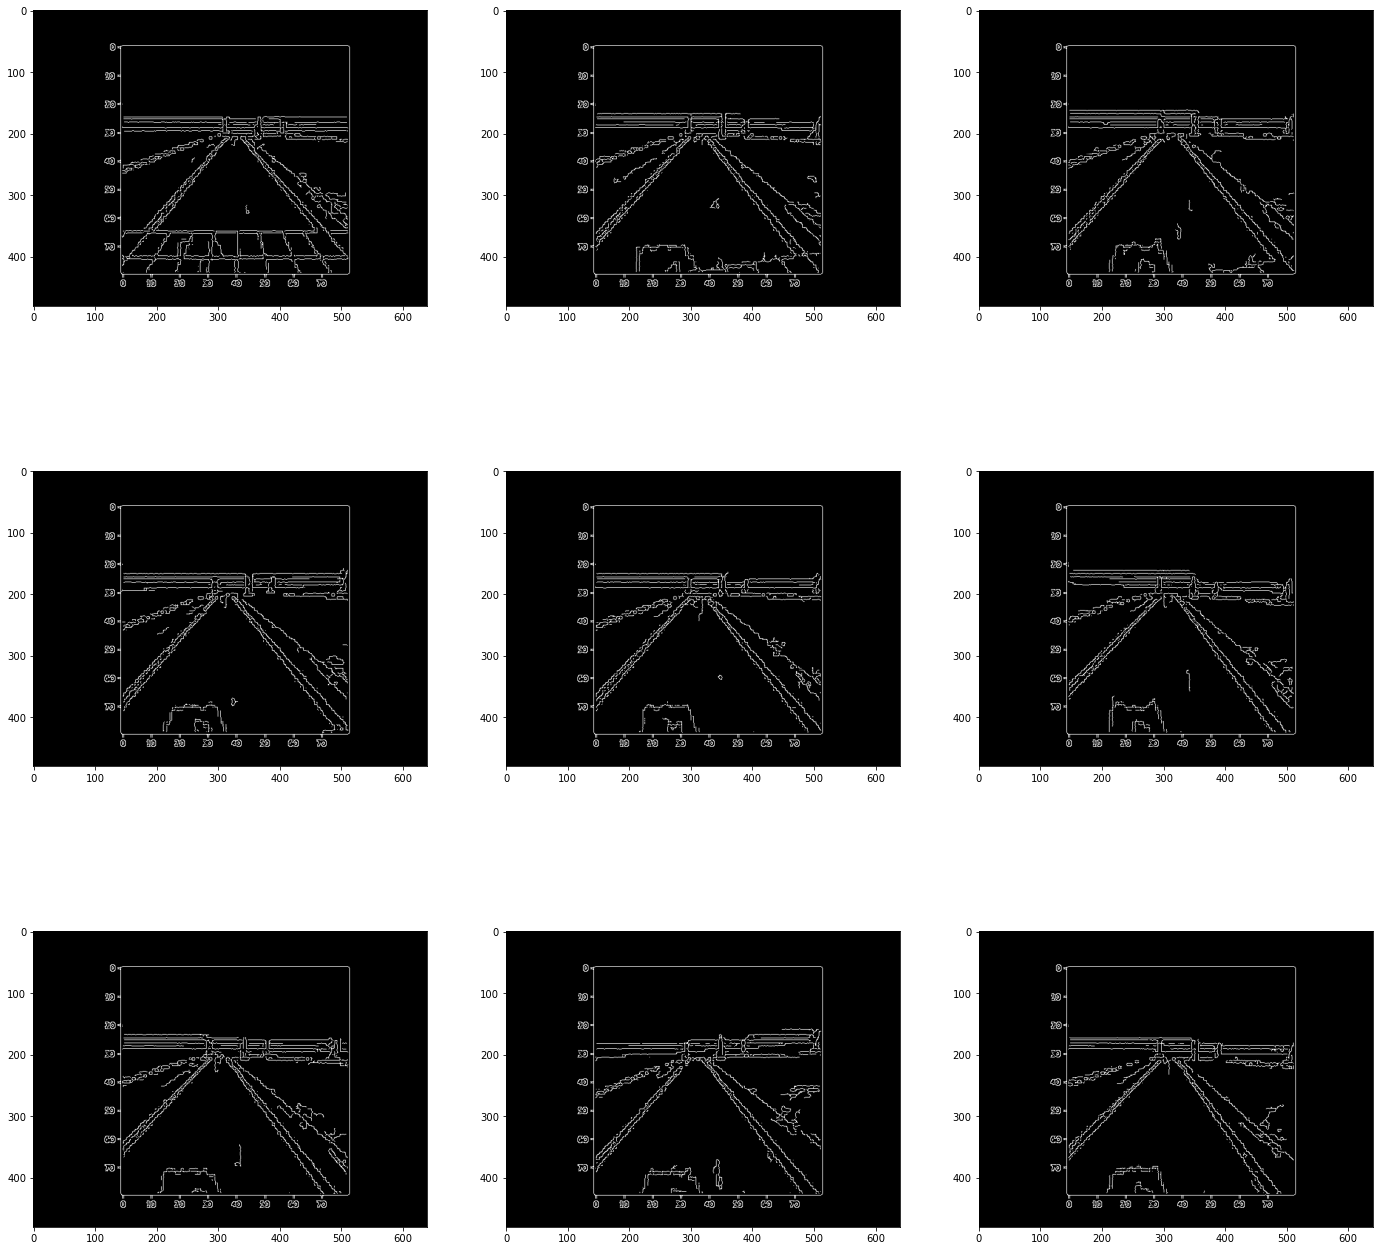

In [27]:
low_threshold = 20
high_threshold = 80 
kernel_size = 7
f = plt.figure(figsize=(24,24))
for i in range(9):
    im = cv2.imread("{}.png".format(i))
    im_blurred = cv2.GaussianBlur(im, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(im_blurred, low_threshold, high_threshold)
    f.add_subplot(3,3,i+1)
    plt.imshow(im_edge, cmap="gray")

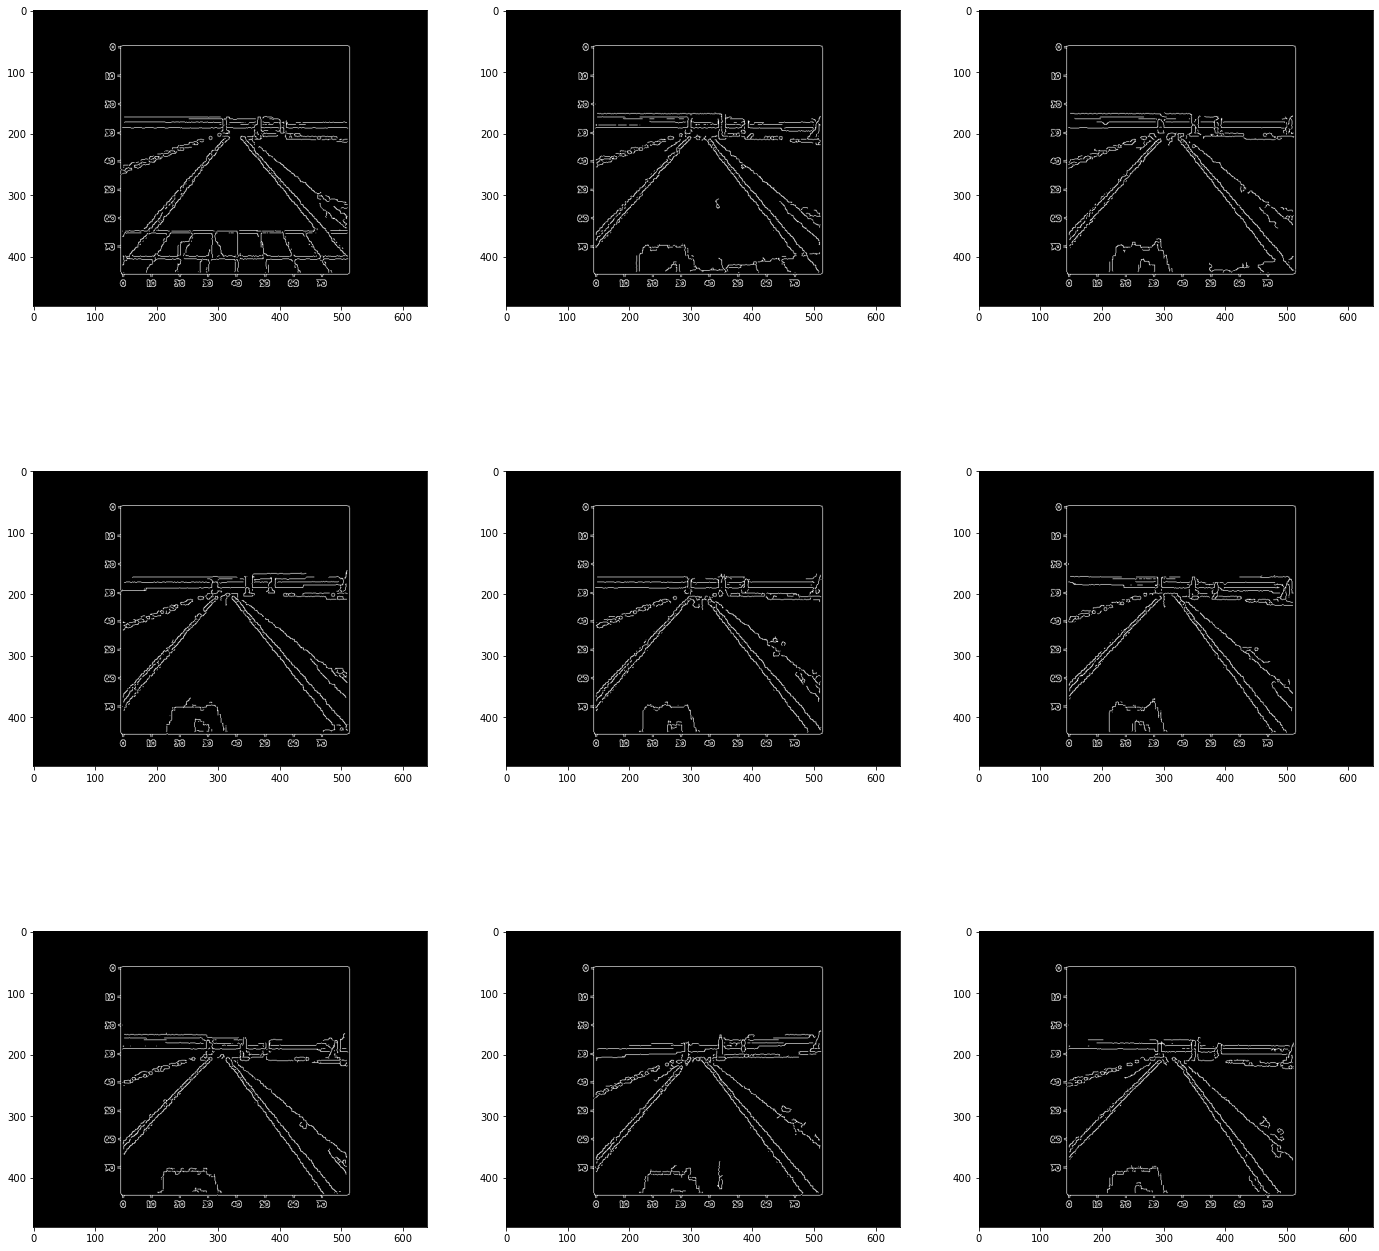

In [28]:
low_threshold = 20
high_threshold = 80 
kernel_size = 9
f = plt.figure(figsize=(24,24))
for i in range(9):
    im = cv2.imread("{}.png".format(i))
    im_blurred = cv2.GaussianBlur(im, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(im_blurred, low_threshold, high_threshold)
    f.add_subplot(3,3,i+1)
    plt.imshow(im_edge, cmap="gray")

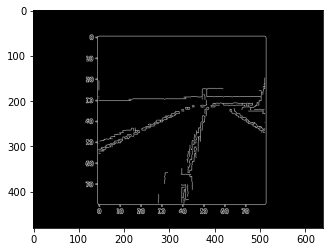

In [14]:
plt.imshow(preprocess_image(im))

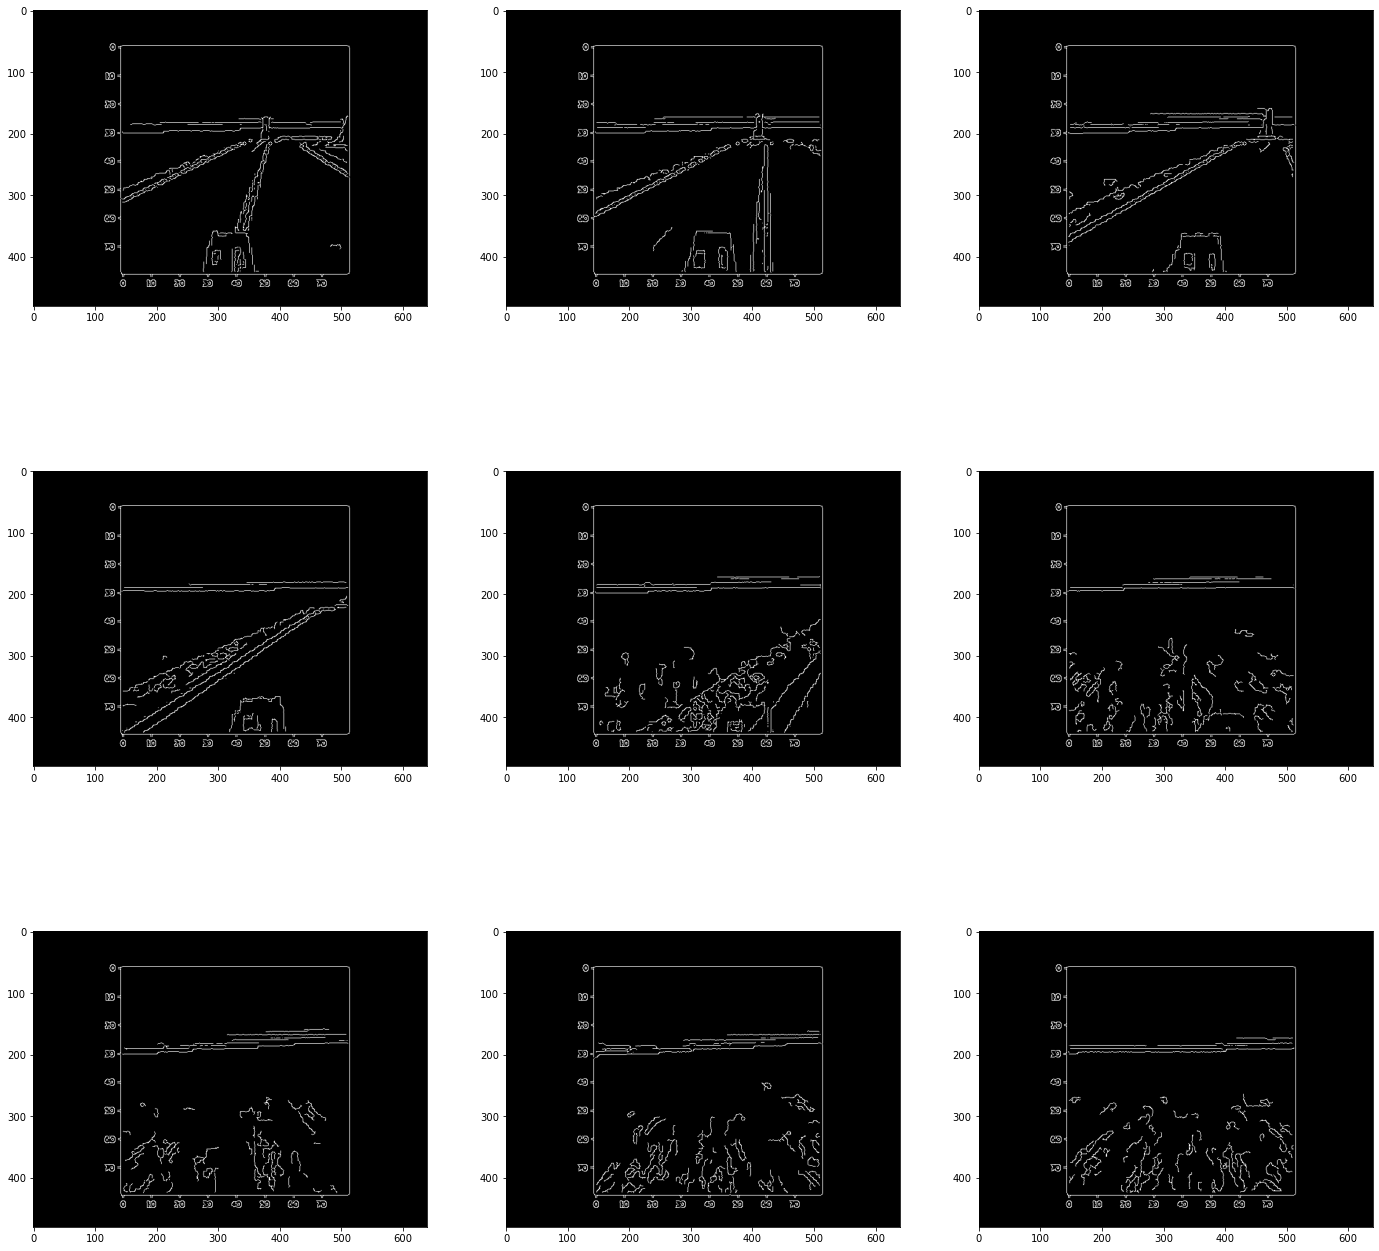

In [33]:
low_threshold = 20
high_threshold = 80 
kernel_size = 9
f = plt.figure(figsize=(24,24))
for i in range(9):
    im = cv2.imread("{}.png".format(i+20))
    im_blurred = cv2.GaussianBlur(im, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(im_blurred, low_threshold, high_threshold)
    f.add_subplot(3,3,i+1)
    plt.imshow(im_edge, cmap="gray")

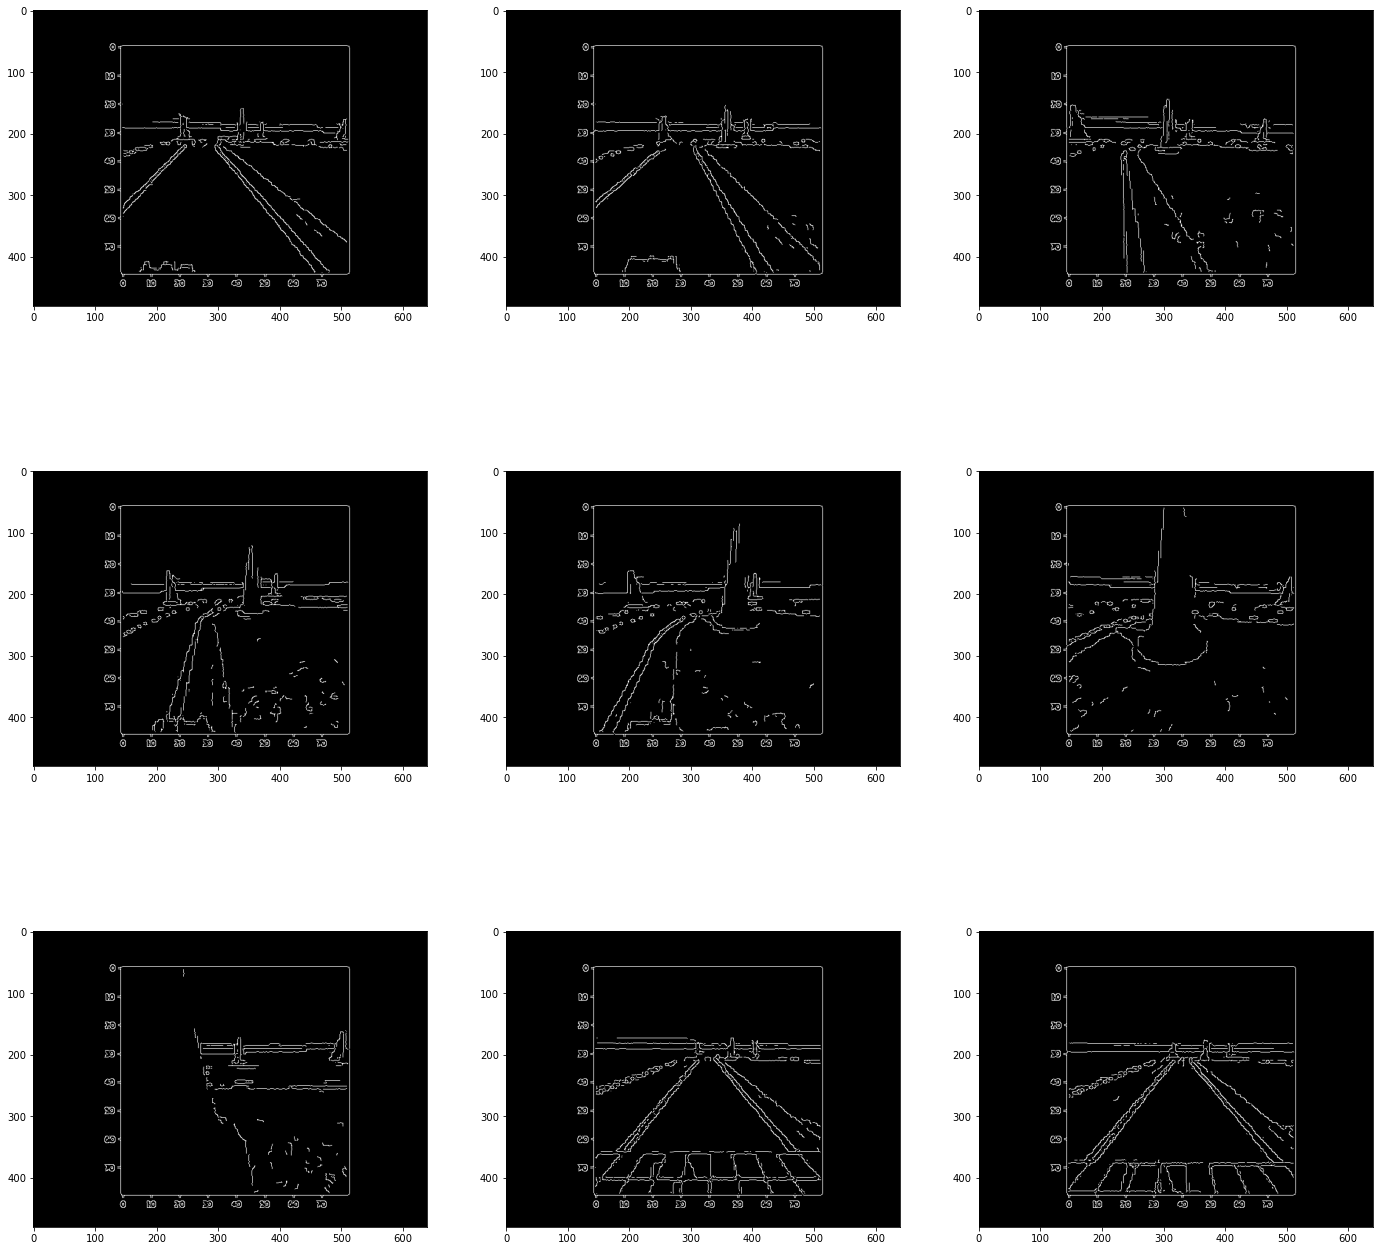

In [49]:
low_threshold = 60
high_threshold = 80 
kernel_size = 9
f = plt.figure(figsize=(24,24))
for i in range(9):
    im = cv2.imread("{}.png".format(i+40))
    im_blurred = cv2.GaussianBlur(im, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(im_blurred, low_threshold, high_threshold)
    f.add_subplot(3,3,i+1)
    plt.imshow(im_edge, cmap="gray")

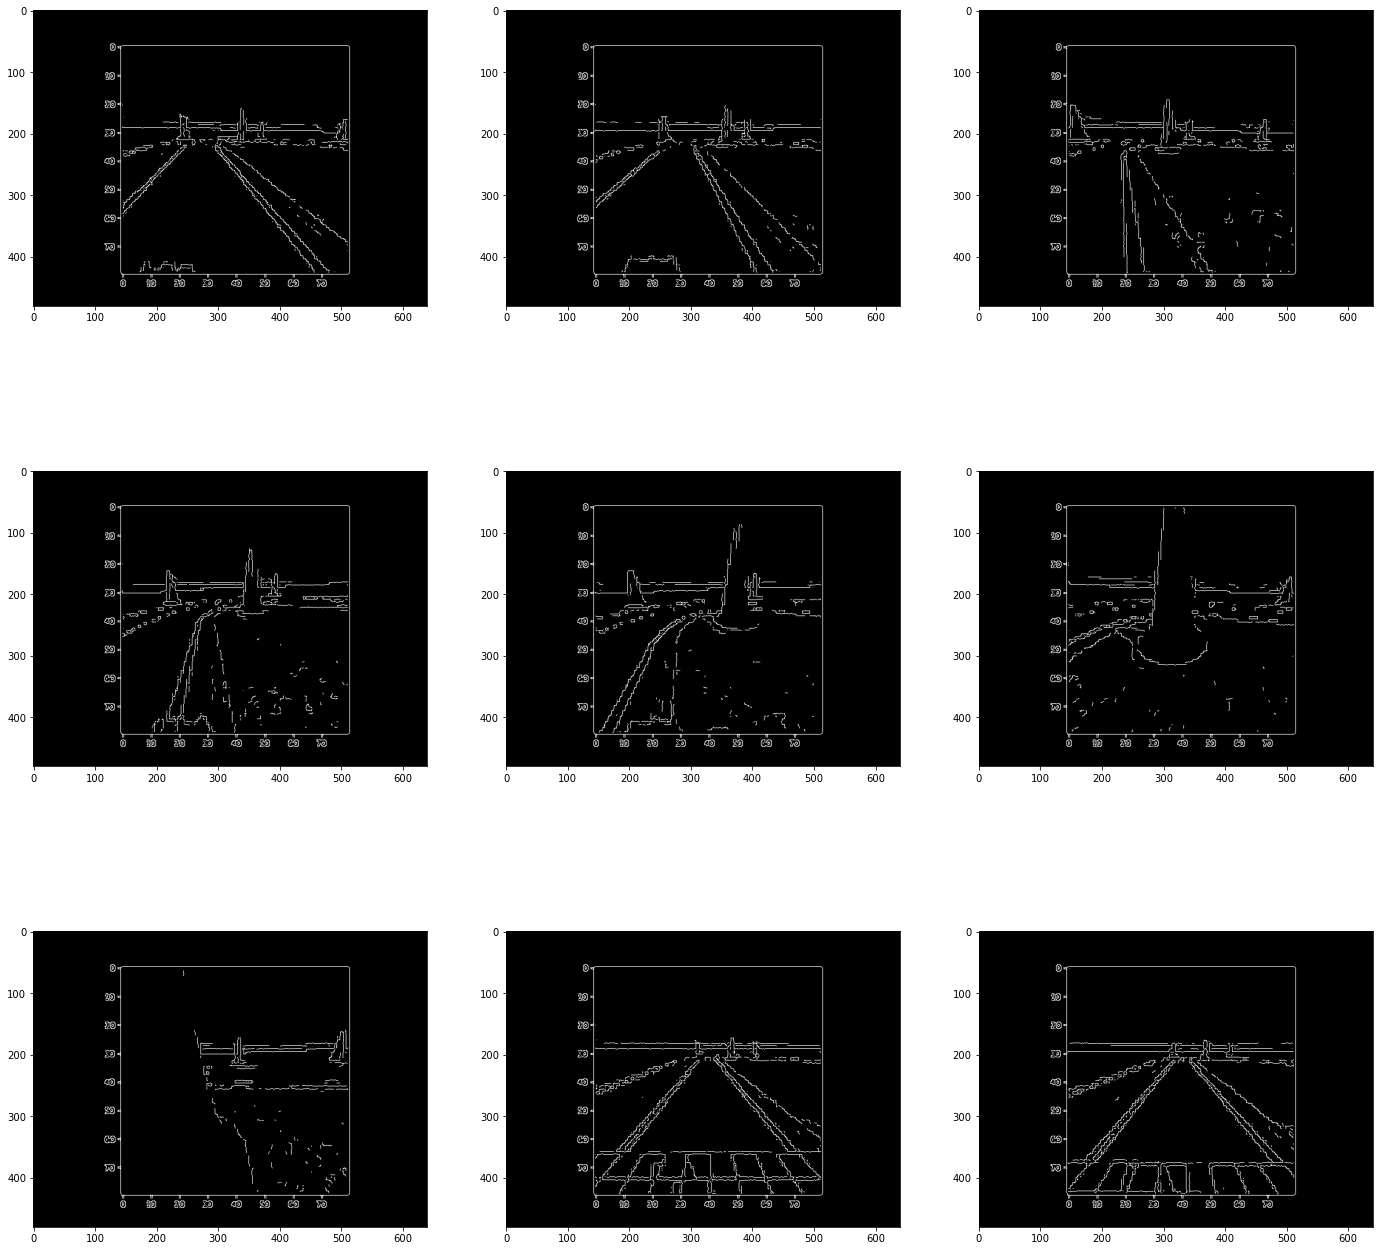

In [48]:
low_threshold = 80
high_threshold = 90 
kernel_size = 7
f = plt.figure(figsize=(24,24))
for i in range(9):
    im = cv2.imread("{}.png".format(i+40))
    im_blurred = cv2.GaussianBlur(im, (kernel_size, kernel_size), 0)
    im_edge = cv2.Canny(im_blurred, low_threshold, high_threshold)
    f.add_subplot(3,3,i+1)
    plt.imshow(im_edge, cmap="gray")

In [50]:
im_edge.shape

(480, 640)

In [51]:
im.shape

(480, 640, 3)